## Fig. 10 - Statistics of VTEC: spatial and temporal variation

In [1]:
%matplotlib inline
import os
import datetime as dt

import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colorbar, ticker, colors
from scipy import interpolate, stats
from shapely.geometry import Point

from mintpy import iono_tec
from mintpy.objects import sensor, ionex
from mintpy.simulation import iono
from mintpy.utils import ptime, readfile, writefile
plt.rcParams.update({'font.size': 12})

proj_dir = os.path.expanduser('~/Papers/2022_GeolocRg/figs_src')
work_dir = os.path.join(proj_dir, 'TEC')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# aux info
tec_dir = os.path.expanduser('~/data/aux/IONEX')
tf_file = os.path.join(work_dir, 'tframe_left_look.gpkg')

inc_angle = 42
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)

Go to directory: /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC


## Read NISAR track-frame info

In [2]:
# read Earth background (for plotting)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

tf_ori_file = os.path.join(proj_dir, 'data/NISAR_track_frames/tframe_left_look.gpkg')
re_generate = False
if os.path.isfile(tf_file) and not re_generate:
    print(f'read {tf_file}')
    tfs = gpd.read_file(tf_file)

else:
    print(f'read {tf_ori_file}')
    tfs = gpd.read_file(tf_ori_file)

    # set CRS
    tfs.crs = "EPSG:4326"

    # calc lat/lon for the center of frames on the ground
    centroid = tfs.geometry.to_crs(epsg=3395).centroid.to_crs(tfs.crs)
    # correct frames crossing the 180 longitude [int. date line]
    xmin = tfs.geometry.bounds.minx
    xmax = tfs.geometry.bounds.maxx
    inds = np.where((xmax - xmin) > 180)[0]
    for ind in inds:
        polys = tfs.iloc[ind].geometry.geoms
        areas = [p.area for p in polys]
        centroid[ind] = polys[np.argmax(areas)].centroid

    # calc lat/lon of the center of frames on the ionospheric thin shell
    hgt_ion = 450e3
    xoff = (tfs.satelliteLon - centroid.x)
    xoff[xoff >  180] -= 360.
    xoff[xoff < -180] += 360.
    lon_ion = centroid.x + hgt_ion / tfs.satelliteHeight * xoff
    lat_ion = centroid.y + hgt_ion / tfs.satelliteHeight * (tfs.satelliteLat - centroid.y)
    lon_ion[lon_ion >=  180] -= 360.
    lon_ion[lon_ion <= -180] += 360.

    # write lat/lon to file
    tfs['groundLon'] = centroid.x
    tfs['groundLat'] = centroid.y
    tfs['ionoPiercingPointLon'] = lon_ion
    tfs['ionoPiercingPointLat'] = lat_ion
    tfs.to_file(tf_file, driver='GPKG')
    print('write to file: {}'.format(tf_out_file))

# grab a few frequently used variables
flagA = tfs.passDirection.isin(['Ascending'])
flagD = tfs.passDirection.isin(['Descending'])
lat_ion = tfs['ionoPiercingPointLat']
lon_ion = tfs['ionoPiercingPointLon']
lat_gnd = tfs['groundLat']
lon_gnd = tfs['groundLon']

# plot longitude to make sure the value is right across the int. date line
plot_IPP_loc = False
if plot_IPP_loc:
    cmap = plt.get_cmap('viridis')
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[9, 9], sharex=True, sharey=True)
    for ax, flag, title in zip(axs, [flagA, flagD], ['ASC', 'DSC']):
        tfs[flag].plot(ax=ax, facecolor=cmap((lon_ion[flag]+180)/360), edgecolor='none')
        world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
        # axis format
        ax.set_aspect('equal');  ax.set_xlim(-180, 180);  ax.set_ylim(-87.5, 78)
        ax.set_title(title)
    fig.tight_layout()
    plt.show()
print('Done.')

read /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/tframe_left_look.gpkg
Done.


### Download JLR TEC for the year of 2014 and 2019

In [3]:
tec_files = []
for year in range(2014, 2020):
    date_list = ptime.get_date_range(f'{year}0101', f'{year}1231')
    tec_files += iono_tec.download_ionex_files(date_list, tec_dir, sol_code='jpl')


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 365
local TEC file directory: /Users/yunjunz/data/aux/IONEX
ALL files exists with consistent file size (~840 KB) --> skip re-downloading.


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 365
local TEC file directory: /Users/yunjunz/data/aux/IONEX
ALL files exists with consistent file size (~840 KB) --> skip re-downloading.


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_

### Calculate TEC time-series for each NISAR track and frame

In [4]:
# get datetime objects of one cycle [from J2000/ephemeris time to UTC]
dts_sat = [dt.datetime(2000,1,1,12,0,0) + dt.timedelta(seconds=(tf.startET + tf.endET)/2.0) for i, tf in tfs.iterrows()]
mins_sat = [x.hour * 60. + x.minute + x.second / 60. for x in dts_sat]

solar_timeA = ptime.utc2solar_time(np.array(dts_sat)[flagA][1],    lon_gnd.to_numpy()[flagA][1])
solar_timeD = ptime.utc2solar_time(np.array(dts_sat)[flagD][1000], lon_gnd.to_numpy()[flagD][1000])
print('Asc  local solar time: {}'.format(solar_timeA.time()))
print('Desc local solar time: {}'.format(solar_timeD.time()))

# get datetime objects of all TEC grids
tec_file = ionex.get_ionex_filename('20140101', tec_dir=tec_dir)
mins, lats, lons = ionex.read_ionex(tec_file)[:3]

Asc  local solar time: 05:37:14.217321
Desc local solar time: 18:32:46.517842


In [17]:
# calculate TEC time-series for all frames
debug_mode = False
years = np.arange(2014, 2020) if not debug_mode else np.arange(2016, 2017)
tec_tf_files = [os.path.join(work_dir, f'TEC_tframe_{year}.csv') for year in years]
re_calc = False
for year, tec_tf_file in zip(years, tec_tf_files):
    if not os.path.isfile(tec_tf_file) or re_calc:
        # calc TEC on each frame
        date_rng = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31') if not debug_mode else pd.date_range(start=f'{year}-01-01', end=f'{year}-01-03')
        num_date = date_rng.size
        tec_tfs = np.zeros((num_date, tfs.geometry.count()), dtype=np.float32)
        prog_bar = ptime.progressBar(maxValue=num_date)
        for i in range(num_date):
            date_str = date_rng[i].strftime('%Y%m%d')
            tec_file = ionex.get_ionex_filename(date_str, tec_dir=tec_dir)
            tec_tfs[i, :] = ionex.get_ionex_value(
                tec_file,
                utc_sec=np.array(mins_sat)*60,
                lat=lat_ion,
                lon=lon_ion,
                interp_method='linear3d',
                rotate_tec_map=True,
                print_msg=False)
            prog_bar.update(i+1, suffix=date_str)
        prog_bar.close()

        # write TEC time-series to CSV file using pandas
        prog_bar = ptime.progressBar(maxValue=tfs.geometry.count())
        tec_df = pd.DataFrame(date_rng, columns=['date'])
        for i, row in tfs.iterrows():
            col_name = f'track{row.track}-frame{row.frame}'
            tec_df[col_name] = tec_tfs[:, i]
            prog_bar.update(i+1, every=176, suffix=col_name.split('-')[0])
        prog_bar.close()
        tec_df = tec_df.set_index('date')
        print('write to file: {}'.format(tec_tf_file))
        tec_df.to_csv(tec_tf_file)
    else:
        print(f'{tec_tf_file} file exists, skip re-calculating.')

# read for stats and ploting
tec_dfs = []
for tec_ts_file in tec_tf_files:
    print('reading {}'.format(tec_ts_file))
    tec_dfs.append(pd.read_csv(tec_ts_file, index_col=0))

/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2014.csv file exists, skip re-calculating.
/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2015.csv file exists, skip re-calculating.
/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2016.csv file exists, skip re-calculating.
/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2017.csv file exists, skip re-calculating.
/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2018.csv file exists, skip re-calculating.
/Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2019.csv file exists, skip re-calculating.
reading /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2014.csv
reading /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2015.csv
reading /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2016.csv
reading /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2017.csv
reading /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/TEC_tframe_2018.c

### Impact of interpolation on VTEC estimation for SAR orbits

[==================================================]    9s /     0s 
[==================================================]   18s /     0s 
save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/pic/20140101_NIA_lin2d.png
save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/pic/20140101_NIA_lin3d.png
save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/pic/20140101_NIA_lin3dRot.png


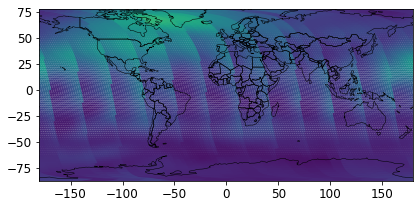

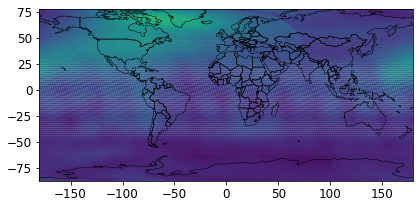

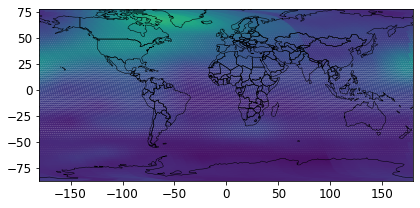

In [5]:
## Test interpolation method
test_interp_method = True
if test_interp_method:
    date_str = '20140101'
    tec_file = ionex.get_ionex_filename(date_str, tec_dir=tec_dir)
    tec_tf1 = ionex.get_ionex_value(tec_file, np.array(mins_sat)*60, lat_ion, lon_ion, interp_method='linear2d', rotate_tec_map=False)
    tec_tf2 = ionex.get_ionex_value(tec_file, np.array(mins_sat)*60, lat_ion, lon_ion, interp_method='linear3d', rotate_tec_map=False)
    tec_tf3 = ionex.get_ionex_value(tec_file, np.array(mins_sat)*60, lat_ion, lon_ion, interp_method='linear3d', rotate_tec_map=True)

    for tec_tf, suffix in zip([tec_tf1, tec_tf2, tec_tf3], ['lin2d', 'lin3d', 'lin3dRot']):
        fig, ax = plt.subplots(figsize=[6, 3])
        cmap = plt.get_cmap('viridis')
        tfs[flagA].plot(ax=ax, facecolor=cmap((tec_tf[flagA])/75), edgecolor='none')
        world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
        ax.set_aspect('equal');  ax.set_xlim(-180, 180);  ax.set_ylim(-87.5, 78)
        fig.tight_layout()
        # output
        out_fig = os.path.abspath(f'pic/{date_str}_NIA_{suffix}.png')
        print('save figure to file:', out_fig)
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

## Plot

In [18]:
# total bounding box [to guide the plot extent]
W, S, E, N = tfs.total_bounds
print(f'S, N, W, E = {S:.2f}, {N:.2f}, {W:.2f}, {E:.2f}')

S, N, W, E = -88.06, 77.63, -180.00, 180.00


### Overall Stats

In [34]:
# overwrite the pandas.DataFrame.mad(), which returns the mean abs dev and is deprecated.
def mad(df):
    """Calculate the median absolute deviation."""
    return (df - df.median()).abs().median()

for tec_df, year in zip(tec_dfs, years):
    print('Year: {}'.format(year))
    for dlabel, data in zip(['avg', 'STD', 'med', 'MAD'], [tec_df.mean(), tec_df.std(), tec_df.median(), mad(tec_df)]):
        print('  {} [min/mean/max] {}: {:4.1f} / {:4.1f} / {:4.1f}'.format(dlabel, year, data.min(), data.mean(), data.max()))

Year: 2014
  avg [min/mean/max] 2014: 10.4 / 23.8 / 74.8
  STD [min/mean/max] 2014:  2.7 /  9.0 / 25.8
  med [min/mean/max] 2014:  8.8 / 24.0 / 71.8
  MAD [min/mean/max] 2014:  1.7 /  7.0 / 23.1
Year: 2015
  avg [min/mean/max] 2015:  8.5 / 19.1 / 60.2
  STD [min/mean/max] 2015:  2.2 /  7.6 / 21.5
  med [min/mean/max] 2015:  6.3 / 18.1 / 56.4
  MAD [min/mean/max] 2015:  1.3 /  5.9 / 18.6
Year: 2016
  avg [min/mean/max] 2016:  5.6 / 13.2 / 40.4
  STD [min/mean/max] 2016:  1.2 /  4.8 / 14.6
  med [min/mean/max] 2016:  4.4 / 12.9 / 38.7
  MAD [min/mean/max] 2016:  0.7 /  3.6 / 12.2
Year: 2017
  avg [min/mean/max] 2017:  4.5 / 10.5 / 29.0
  STD [min/mean/max] 2017:  0.8 /  3.4 / 10.0
  med [min/mean/max] 2017:  3.6 / 10.4 / 29.2
  MAD [min/mean/max] 2017:  0.5 /  2.8 /  9.1
Year: 2018
  avg [min/mean/max] 2018:  3.8 /  9.1 / 24.5
  STD [min/mean/max] 2018:  0.6 /  2.9 /  8.3
  med [min/mean/max] 2018:  3.2 /  8.8 / 24.5
  MAD [min/mean/max] 2018:  0.4 /  2.3 /  7.6
Year: 2019
  avg [min/mea

### Calculate temporal stats in 2014 & 2019 for plotting

In [46]:
label = 'median';  #label = 'mean'
#label = 'MAD';    #label = 'STD'
print(f'label = {label}')

# temporal stats
if label == 'mean':
    dDict = {'A2014' : {'data': tec_dfs[years.tolist().index(2014)].mean().to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': tec_dfs[years.tolist().index(2019)].mean().to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': tec_dfs[years.tolist().index(2014)].mean().to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': tec_dfs[years.tolist().index(2019)].mean().to_numpy()[flagD], 'flag': flagD}}
elif label == 'STD':
    dDict = {'A2014' : {'data': tec_dfs[years.tolist().index(2014)].std().to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': tec_dfs[years.tolist().index(2019)].std().to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': tec_dfs[years.tolist().index(2014)].std().to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': tec_dfs[years.tolist().index(2019)].std().to_numpy()[flagD], 'flag': flagD}}
elif label == 'median':
    dDict = {'A2014' : {'data': tec_dfs[years.tolist().index(2014)].median().to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': tec_dfs[years.tolist().index(2019)].median().to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': tec_dfs[years.tolist().index(2014)].median().to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': tec_dfs[years.tolist().index(2019)].median().to_numpy()[flagD], 'flag': flagD}}
elif label == 'MAD':
    dDict = {'A2014' : {'data': mad(tec_dfs[years.tolist().index(2014)]).to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': mad(tec_dfs[years.tolist().index(2019)]).to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': mad(tec_dfs[years.tolist().index(2014)]).to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': mad(tec_dfs[years.tolist().index(2019)]).to_numpy()[flagD], 'flag': flagD}}

keys = list(dDict.keys())
# overall stats
vmax = 0
for key, v in dDict.items():
    rg_min_ni = iono.vtec2range_delay(np.min(v['data']), inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
    rg_max_ni = iono.vtec2range_delay(np.max(v['data']), inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
    rg_min_s1 = iono.vtec2range_delay(np.min(v['data']), inc_angle=inc_angle_iono, freq=iono.SAR_BAND['C'])
    rg_max_s1 = iono.vtec2range_delay(np.max(v['data']), inc_angle=inc_angle_iono, freq=iono.SAR_BAND['C'])
    vmax = np.ceil(max(vmax, np.max(v['data'])))
    print(key)
    print('  VTEC     min / max: {:4.0f} / {:4.0f} TECU'.format(np.min(v['data']), np.max(v['data'])))
    print('  rg delay min / max: {:4.1f} / {:4.1f} m for NISAR-L or {:4.0f} / {:4.0f} cm for Sentinel-1'.format(rg_min_ni, rg_max_ni, rg_min_s1*100, rg_max_s1*100))
print(f'vmax = {vmax} TECU')

label = median
A2014
  VTEC     min / max:    9 /   23 TECU
  rg delay min / max:  2.3 /  5.8 m for NISAR-L or   15 /   36 cm for Sentinel-1
A2019
  VTEC     min / max:    3 /    9 TECU
  rg delay min / max:  0.7 /  2.3 m for NISAR-L or    5 /   15 cm for Sentinel-1
D2014
  VTEC     min / max:   13 /   72 TECU
  rg delay min / max:  3.3 / 18.3 m for NISAR-L or   21 /  104 cm for Sentinel-1
D2019
  VTEC     min / max:    3 /   22 TECU
  rg delay min / max:  0.9 /  5.7 m for NISAR-L or    6 /   35 cm for Sentinel-1
vmax = 72.0 TECU


### Plot 1 - maps

save figure to file: /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/map_median.png


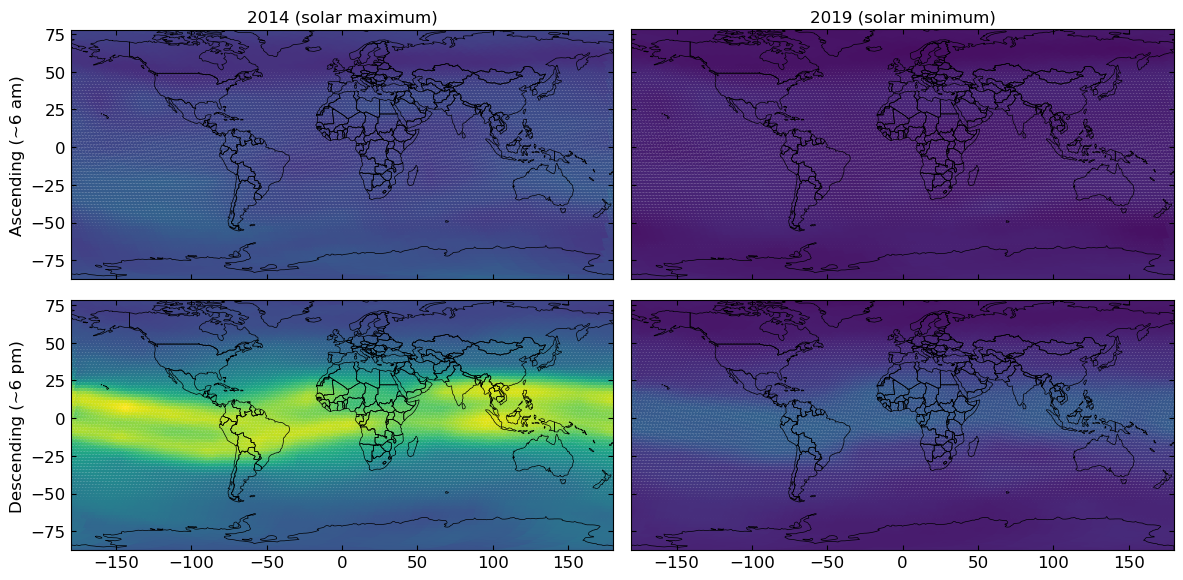

In [47]:
# plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[12, 6], sharex=True, sharey=True)
axs = axs.flatten()
cmap = plt.get_cmap('viridis')
for i, (ax, key) in enumerate(zip(axs, keys)):
    v = dDict[key]
    tfs[v['flag']].plot(ax=ax, facecolor=cmap(v['data']/vmax), edgecolor='none')
    world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)

# axis format
for ax in axs: ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
ax = axs[0]
ax.set_aspect('equal')
ax.set_xlim(-180, 180)
ax.set_ylim(-87.5, 78)
axs[0].set_ylabel('Ascending (~6 am)')
axs[2].set_ylabel('Descending (~6 pm)')
axs[0].set_title('2014 (solar maximum)', fontsize=12)
axs[1].set_title('2019 (solar minimum)', fontsize=12)
fig.tight_layout()

# output
out_fig = os.path.abspath(f'map_{label.lower()}.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### Plot 2 - color bar

max VTEC: 72.0 [TECU]
max range delay: 18.4 [m] for NISAR-L
save figure to file: /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/cbar_median.png


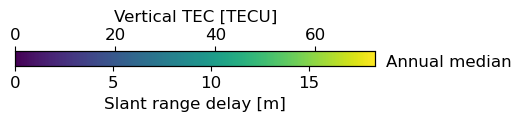

In [48]:
rg_max = iono.vtec2range_delay(vmax, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
print('max VTEC: {} [TECU]'.format(vmax))
print('max range delay: {:.1f} [m] for NISAR-L'.format(rg_max))

# colorbars
# link: https://stackoverflow.com/questions/27151098/draw-colorbar-with-twin-scales
fig = plt.figure(figsize=(4, 0.15))
ax = fig.add_axes([0.05, 0.05, 0.95, 0.95])
# define my own ScalarMappable instead of relying on imshow() 
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=colors.Normalize(vmin=0, vmax=rg_max))
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')

# the aspect of the colorbar is set to 'equal', we have to set it to 'auto',
# otherwise twinx() will do weird stuff.
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')
# create a second axes instance and set the limits you need
ax2 = cbar.ax.twiny()
ax2.set_xlim([0, vmax])
# resize the colorbar (otherwise it overlays the plot)
pos.x0 += 0.05
cbar.ax.set_position(pos)
ax2.set_position(pos)
# label
cbar.ax.set_xlabel('Slant range delay [m]')
ax2.set_xlabel('Vertical TEC [TECU]')
ax.annotate(f'Annual {label}', xy=(1.03, 0.), xycoords='axes fraction')

# output
out_fig = os.path.abspath(f'cbar_{label.lower()}.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### Plot 3 - Profiles (multi-years)

save figure to file: /Users/yunjunz/Papers/2022_GeolocRg/figs_src/TEC/profile_median.png


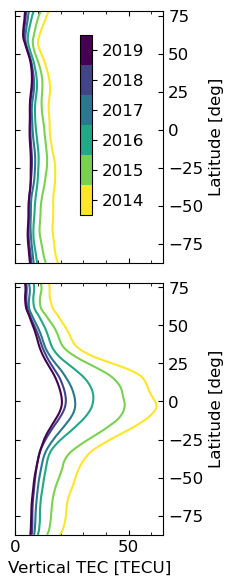

In [49]:
bin_rng = (-88, 78);  bin_step = 2;
num_bin = int((bin_rng[1] - bin_rng[0]) / bin_step); bin_cen = np.arange(bin_rng[0], bin_rng[1], bin_step) + bin_step/2
cmap = plt.get_cmap('viridis_r', lut=len(tec_dfs))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[2.5, 6], sharex=True, sharey=True)
for ax, flag in zip(axs, [flagA, flagD]):
    tlat = lat_gnd.to_numpy()[flag]
    for i, (tec_df, year) in enumerate(zip(tec_dfs, years)):
        if label == 'mean':
            tval = tec_df.mean().to_numpy()[flag]
        elif label == 'STD':
            tval = tec_df.std().to_numpy()[flag]
        elif label == 'median':
            tval = tec_df.median().to_numpy()[flag]
        elif label == 'MAD':
            tval = mad(tec_df).to_numpy()[flag]
        bin_tec = stats.binned_statistic(x=tlat, values=tval, bins=num_bin, range=bin_rng)[0]
        ax.plot(bin_tec, bin_cen, color=cmap(i))
# axis format
for ax in axs:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
    ax.set_ylabel('Latitude [deg]')
axs[1].set_ylim(-87.5, 78)
axs[1].set_xlim(0)
axs[1].set_xlabel('Vertical TEC [TECU]')
axs[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.tight_layout()
fig.subplots_adjust(hspace=0.08)

# colorbar
cax = fig.add_axes([0.35, 0.63, 0.05, 0.3])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, ticks=(np.arange(len(years)) + 0.5) / len(years))
cbar.ax.set_yticklabels(years)

# output
out_fig = os.path.abspath(f'profile_{label.lower()}.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

## Backups

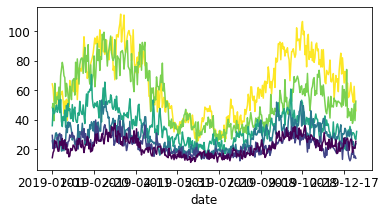

In [180]:
# track frame number for Mexico City
inds = np.where((centroid.x > -101) & (centroid.x < -97) & (centroid.y > 17) & (centroid.y < 21))[0]
indA, indD = inds[1], inds[-2]
tfnameA = 'track{}-frame{}'.format(tfs.iloc[indA].track, tfs.iloc[indA].frame)
tfnameD = 'track{}-frame{}'.format(tfs.iloc[indD].track, tfs.iloc[indD].frame)

# plot
cmap = plt.get_cmap('viridis_r', lut=len(tec_dfs))
fig, ax = plt.subplots(figsize=[6, 3])
for i, tec_df in enumerate(tec_dfs):
    tec_df[tfnameA].plot(ax=ax, color=cmap(i))
plt.show()